# Evaluate AMORS methods
This notebook explores the results of evaluating the AMORS and VectAMORS algorithms with different hyperparameters and data conditions

Copyright (c) 2024 University of Strasbourg
Author: Massyl Moudoud <mmoudoud@unistra.fr> 
Contributor(s) : Céline Meillier <meillier@unistra.fr>, Vincent Mazet <vincent.mazet@unistra.fr>

This work has been supported by the ANR project DynaSTI: ANR-22-CE45-0008

This software is governed by the CeCILL  license under French law and
abiding by the rules of distribution of free software.  You can  use, 
modify and/ or redistribute the software under the terms of the CeCILL
license as circulated by CEA, CNRS and INRIA at the following URL
"http://www.cecill.info". 

As a counterpart to the access to the source code and  rights to copy,
modify and redistribute granted by the license, users are provided only
with a limited warranty  and the software's author,  the holder of the
economic rights,  and the successive licensors  have only  limited
liability. 

In this respect, the user's attention is drawn to the risks associated
with loading,  using,  modifying and/or developing or reproducing the
software by the user in light of its specific status of free software,
that may mean  that it is complicated to manipulate,  and  that  also
therefore means  that it is reserved for developers  and  experienced
professionals having in-depth computer knowledge. Users are therefore
encouraged to load and test the software's suitability as regards their
requirements in conditions enabling the security of their systems and/or 
data to be ensured and,  more generally, to use and operate it in the 
same conditions as regards security. 

The fact that you are presently reading this means that you have had
knowledge of the CeCILL license and that you accept its terms.

In [1]:
# If you have a valid latex install set to True
# to render figure legends and labels in Latex style
use_Latex = False

In [2]:
# Set paths
import pathlib
try:
    script_path = str(pathlib.Path(__file__).parent.resolve()) +"/"
except NameError:
    script_path = ""

In [3]:
#Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import json
import gzip

functionPath = script_path + "../src"
sys.path.append(functionPath)

from utile.eval_error import get_rescaled_errors

In [4]:
# Check is latex is used
if use_Latex:
    matplotlib.rcParams.update({'font.size': 20, 'text.usetex' : True, 'font.family':"ptm"})
    matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
else: 
    plt.rcParams.update({'font.size': 20})
    

In [5]:
#disable warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
#load ground truth data
datapath = script_path + "../data/simulation/simulation_A_D_2024_12_18.npz"

data  = np.load(datapath)
A_VT = data["A"]
D_VT = data["D"]

E, P = D_VT.shape
T = A_VT.shape[1]

D_tilde = np.int32(D_VT != 0)
C_VT = D_VT @ A_VT

# Effect of $\lambda_{\ell_1}$ and $\lambda_{TV}$ hyperparameters

In [9]:
resultpath = script_path + "../scripts/optimization_results/"

In [10]:
snr_val = 0


res_path = resultpath + f"FISTA_multi_realisation_result_A_D_SNR_{snr_val}.json.gz"
with gzip.open(res_path, 'rt', encoding='UTF-8') as zipfile:
        res_A_D = json.load(zipfile)
        
        
#Convert back array to numpy
for i , res in enumerate(res_A_D):
    for key, val in res.items():
        res_A_D[i][key] = np.array(val)
        
#keep track of the variables names in the array
idx_to_var = {idx : var for idx ,var in enumerate(res_A_D[0].keys())}
var_to_idx = {var : idx for idx ,var in enumerate(res_A_D[0].keys())}

Nb_experiments = len(res_A_D)

In [11]:
labels_dict = {0: "AM-AMORS",
               1: "VectAMORS",
               2: "mean"
              }
labels_var_to_idx = {label:i for i, label in labels_dict.items()}

In [12]:
error = np.zeros((Nb_experiments, 4))
error_AMORS = np.zeros((Nb_experiments, 4))
error_VectAMORS = np.zeros((Nb_experiments, 4))

lambda_L2_D = np.zeros(Nb_experiments)
lambda_L1_A = np.zeros(Nb_experiments)
lambda_TV_A = np.zeros(Nb_experiments)

labels = np.zeros(Nb_experiments)


for i, res in enumerate(res_A_D):
    error[i,:] = res["err"][-1,:]
    error_AMORS[i,:] = res["err_AMORS"][-1,:]
    error_VectAMORS[i,:] = res["err_VectAMORS"][-1,:]
    lambda_L2_D[i] = res["lambda_l2_D"]
    lambda_L1_A[i] = res["lambda_l1_A"]
    lambda_TV_A[i] = res["lambda_TV"]
    
    labels[i] = labels_var_to_idx[str(res["param_label"])]

N_realizations = np.count_nonzero(labels==0)

In [13]:
#rescale estimated matrices with oracle rescaling

for i, res in enumerate(res_A_D):
    error[i,2:] = get_rescaled_errors(res["D_est"],
                                      res["A_est"],
                                      D_VT,
                                      res["A_VT"])
    
    error_AMORS[i,2:] = get_rescaled_errors(res["D_est_AMORS"],
                                            res["A_est_AMORS"],
                                            D_VT, 
                                            res["A_VT"])
    
    error_VectAMORS[i,2:] = get_rescaled_errors(res["D_est_VectAMORS"], 
                                                res["A_est_VectAMORS"], 
                                                D_VT, 
                                                res["A_VT"])

In [14]:
# Convert error to percents

# D
error[:, 2] = error[:, 2]*100/np.linalg.norm(D_VT, ord="fro")
error_AMORS[:, 2] = error_AMORS[:, 2]*100/np.linalg.norm(D_VT, ord="fro")
error_VectAMORS[:, 2] = error_VectAMORS[:, 2]*100/np.linalg.norm(D_VT, ord="fro")

for i, res in enumerate(res_A_D):
    # C
    error[i, 1] = error[i, 1]*100 / np.linalg.norm(D_VT@res["A_VT"], ord="fro")
    error_AMORS[i, 1] = error_AMORS[i, 1]*100 / np.linalg.norm(D_VT@res["A_VT"], ord="fro")
    error_VectAMORS[i, 1] = error_VectAMORS[i, 1]*100 / np.linalg.norm(D_VT@res["A_VT"], ord="fro")
    
    # A
    error[i, 3] = error[i, 3]*100 / np.linalg.norm(res["A_VT"], ord="fro")
    error_AMORS[i, 3] = error_AMORS[i, 3]*100 / np.linalg.norm(res["A_VT"], ord="fro")
    error_VectAMORS[i, 3] = error_VectAMORS[i, 3]*100 / np.linalg.norm(res["A_VT"], ord="fro")

## Error per param set

In [15]:
error_matrices = [ "Criterion" ," C" , "D" , "A"]

for idx, label in labels_dict.items():
    print("#########################################")
    print("The proposed methods has lower error with the best param of", label)
    select_idx = labels == idx
    for i in range(1, 4):
        print("##############")
        print("In" , error_matrices[i])
        print("Compared to classical AM")
        print(np.count_nonzero(error_VectAMORS[select_idx,i] <= error[select_idx,i])*100/N_realizations)
        print("Compared to AMORS")
        print(np.count_nonzero(error_VectAMORS[select_idx,i] <= error_AMORS[select_idx,i])*100/N_realizations)

#########################################
The proposed methods has lower error with the best param of AM-AMORS
##############
In  C
Compared to classical AM
69.0
Compared to AMORS
18.0
##############
In D
Compared to classical AM
74.0
Compared to AMORS
82.0
##############
In A
Compared to classical AM
78.0
Compared to AMORS
90.0
#########################################
The proposed methods has lower error with the best param of VectAMORS
##############
In  C
Compared to classical AM
100.0
Compared to AMORS
100.0
##############
In D
Compared to classical AM
81.0
Compared to AMORS
92.0
##############
In A
Compared to classical AM
91.0
Compared to AMORS
94.0
#########################################
The proposed methods has lower error with the best param of mean
##############
In  C
Compared to classical AM
100.0
Compared to AMORS
98.0
##############
In D
Compared to classical AM
100.0
Compared to AMORS
99.0
##############
In A
Compared to classical AM
100.0
Compared to AMORS
100.0


# Plot error

In [16]:
labels_dict = {0: "$\Theta^{\mathrm{opt}}_{[4,6]}$",
               1: "$\Theta^{\mathrm{opt}}_{\mathrm{prop}}$",
               2: "$\Theta^{\mathrm{opt}}_{\mathrm{moy}}$"
              }

In [17]:
labels_names = pd.Series(np.concatenate((labels, labels, labels))).map(labels_dict)

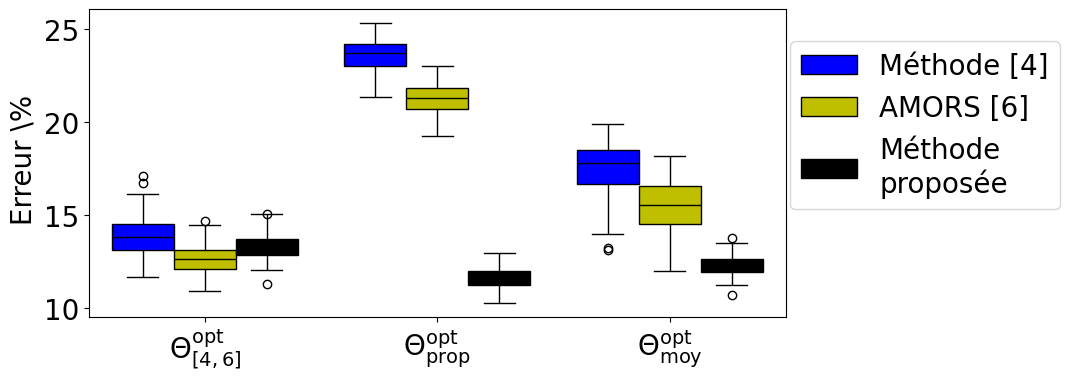

In [18]:
error_matrices = [ "Criterion" ," C" , "D" , "A"]
i = 1 #C
plt.figure(figsize=(9, 4))#layout="constrained" figsize=(8, 4)


df = pd.DataFrame({"Jeu de paramètres": labels_names,
               "Méthode" : [*(["Méthode [4]"] *Nb_experiments), 
                            *(["AMORS [6]"] * Nb_experiments),
                            *(["Méthode\nproposée"] *Nb_experiments)
                           ],
               "EQM" : np.concatenate((error[:, i], error_AMORS[:, i], error_VectAMORS[:, i]))
              })

ax = sns.boxplot(data = df,
                 x = "Jeu de paramètres",
                 y = "EQM",
                 hue = "Méthode",
                 palette= ["b" , "y", "k"],
                 saturation= 1,
                 #linecolor = "g"
                 #legend = False
                 #label = pd.unique(df["Méthode"]) 
                            )

plt.ylabel(" Erreur \%")

plt.xlabel("")
#plt.xticks(rotation=10)
#plt.title(error_matrices[i])

#plt.grid()
legend = plt.legend(loc = (1.006,0.35))#, ncol =3)
# Remove axes legend and let only the figure one
#ax.get_legend().remove()
plt.savefig(script_path + "./figs/Figure3.pdf",
            bbox_extra_artists = [legend],
            bbox_inches ="tight",
            pad_inches = 0.2
           )

# If in script close the figures
if script_path != "":
    plt.close("all")
